In [1]:
import sys
import os
import numpy as np
import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# import h5py
from torchsummary import summary
from dlsia.core import helpers
from dlsia.core.train_scripts import train_regression, train_segmentation
from dlsia.core.networks import smsnet, baggins, tunet
from dlsia.test_data.two_d import build_test_data, torch_hdf5_loader
from dlsia.viz_tools import plots, draw_sparse_network

import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
# import einops

# import napari


from qlty import qlty2D


import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate


This is me cheating and building a raster as we see in the image.
not sure we need it, but I thought I add it in to show how it can be done

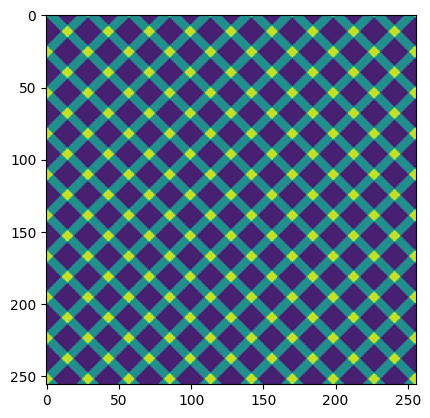

In [2]:
def generate_rotated_heatmap(N, band_width, periodicity, rotation_degrees, shift):
    large_size = int(N * 1.5)  # Make the array large enough to avoid edge effects after rotation
    large_heatmap = np.zeros((large_size, large_size))
    
    for y in range(0, large_size, periodicity):
        start = (y + shift) % large_size
        end = min(start + band_width, large_size)
        large_heatmap[start:end, :] = 1

    rotated_heatmap = rotate(large_heatmap, rotation_degrees, mode='reflect', reshape=False)
    
    crop_x1 = (large_size - N) // 2
    crop_x2 = crop_x1 + N
    crop_y1 = (large_size - N) // 2
    crop_y2 = crop_y1 + N
    
    final_heatmap = rotated_heatmap[crop_y1:crop_y2, crop_x1:crop_x2]
    return final_heatmap


# optically decent values
bands = 0.5*generate_rotated_heatmap(256, 6, 20, 45,7)+0.5*generate_rotated_heatmap(256, 6, 20, -45, 7)
plt.imshow(bands)
plt.show()

In [3]:
dataX = []
dataY = []

for f in sorted(os.listdir("SimARPESForPeter\\SimARPESForPeter\\data_X\\")):
    if 'txt' in f:
        tmp = np.loadtxt("SimARPESForPeter\\SimARPESForPeter\\data_X\\"+f)
        # add the raster as part of the observed data in an added channel
        dataX.append( np.array([tmp, bands]) ) 
        
for f in sorted(os.listdir("SimARPESForPeter\\SimARPESForPeter\\target_Y\\")):
    if 'txt' in f:
        tmp = np.loadtxt("SimARPESForPeter\\SimARPESForPeter\\target_Y\\"+f)
        tmp = ndimage.gaussian_filter(tmp, sigma=1)
        dataY.append(tmp/np.max(tmp))
        
dataX = np.array(dataX)
dataY = np.array(dataY)

In [4]:
# print(dataX.shape, dataY.shape)

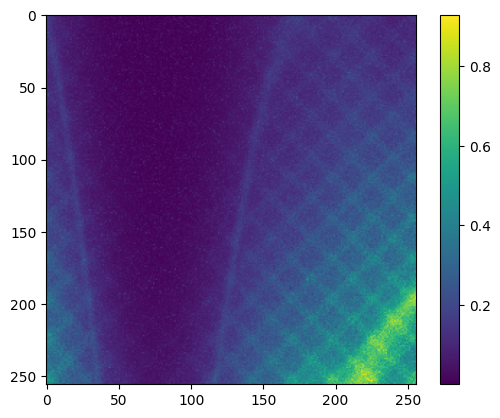

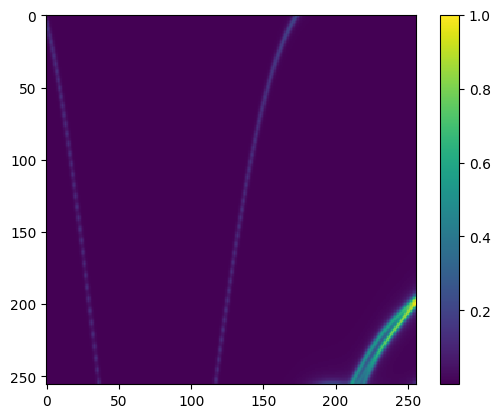

In [5]:
plt.imshow(dataX[0,0])
plt.colorbar()
plt.show()

plt.imshow(dataY[0], interpolation='None')
plt.colorbar()
plt.show()

# napari is nice
# v = napari.view_image(dataY)
# _ = v.add_image(dataX)


In [6]:
GT = torch.Tensor(np.array(dataY)).unsqueeze(1)
OBS = torch.Tensor(np.array(dataX))

print(GT.shape, OBS.shape)

torch.Size([10, 1, 256, 256]) torch.Size([10, 2, 256, 256])


Here we patch it up. I have an RTX3090, so not a whole lot of memory.
Also, by having sliding windows, we essentially augment our data.

In [7]:
qlty_obj = qlty2D.NCYXQuilt(Y=256,X=256,window=(128,128), step=(32,32), border=None, border_weight=0)

In [8]:
# we unstich into pacthes
qGT,qOBS = qlty_obj.unstitch_data_pair(GT,OBS)
print(qGT.shape,qOBS.shape)

torch.Size([250, 1, 128, 128]) torch.Size([250, 2, 128, 128])


In [9]:
train_slice = slice(0,qGT.shape[0],2)
test_slice = slice(1,qGT.shape[0],2)
train_data = TensorDataset(qOBS[train_slice], qGT[train_slice])
validation_data = TensorDataset(qOBS[test_slice], qGT[test_slice])

# train_data = TensorDataset(GT,MSK)
# validation_data = TensorDataset(GT,MSK)

from dataset import NpyDataset
Y=1024
X=1024
window=(256,256)
step=(256,256)
border=None
border_weight=0

train_data = NpyDataset(start_idx=0, end_idx=100, Y=Y, X=X, window=window, step=step, border=border, border_weight=border_weight)
validation_data = NpyDataset(start_idx=100, end_idx=150, Y=Y, X=X, window=window, step=step, border=border, border_weight=border_weight)
qlty_obj = qlty2D.NCYXQuilt(Y=Y, X=X, window=window, step=step, border=border, border_weight=border_weight)

print(validation_data[0][0].shape)
print(len(validation_data))
# plt.imshow(validation_data[2][0][0,:,:])
# plt.show()
# plt.imshow(validation_data[2][1][0,:,:])
# plt.show()

batch_size=16
num_workers=0

loader_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_workers}
train_loader = DataLoader(train_data, **loader_params)
loader_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_workers}
validation_loader = DataLoader(validation_data, **loader_params)

torch.Size([1, 256, 256])
450


Network 1


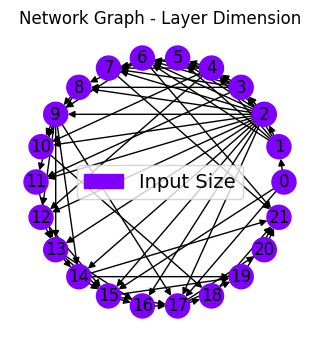

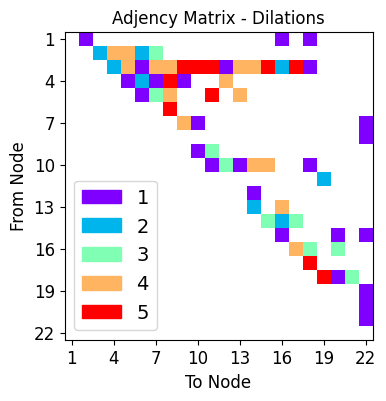

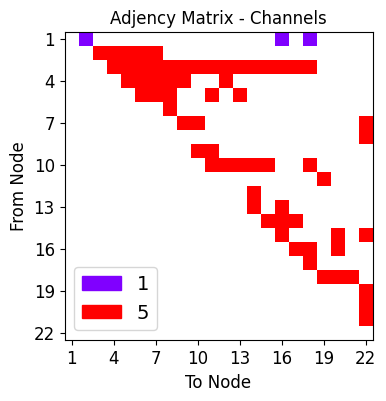

Network 2


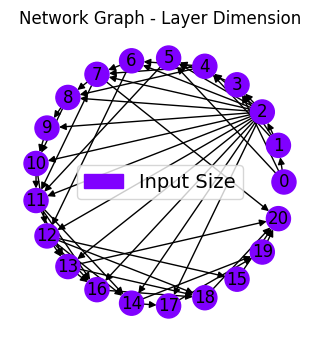

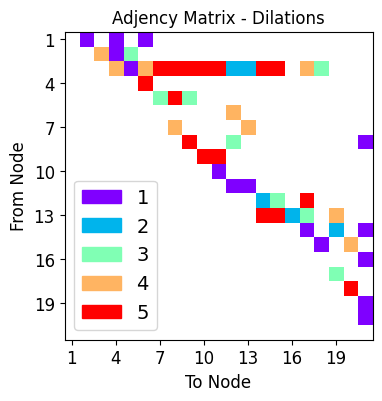

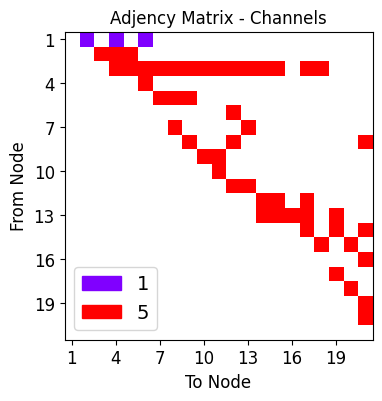

Network 3


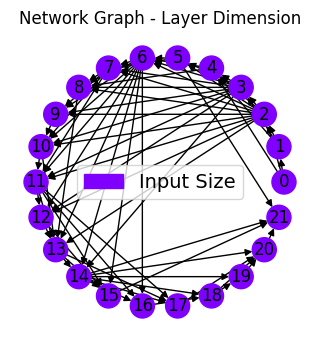

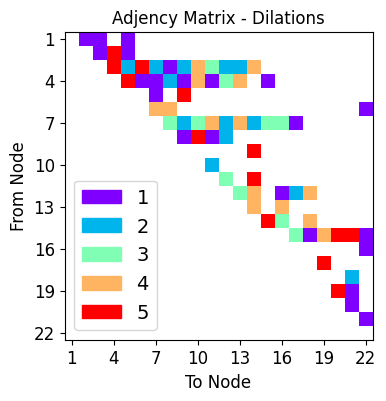

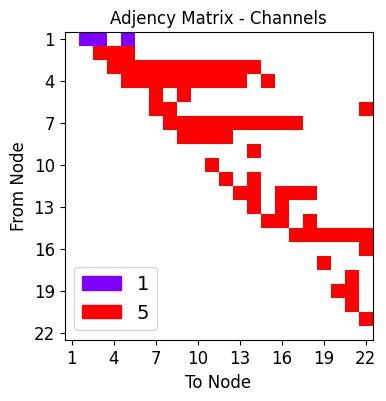

Network 4


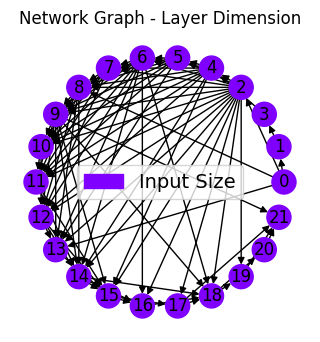

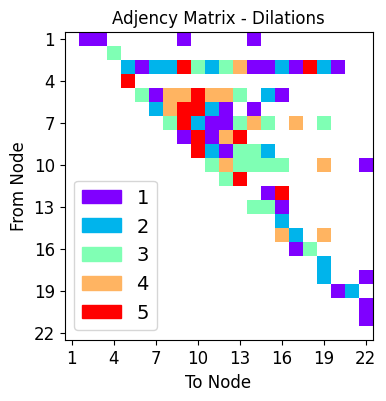

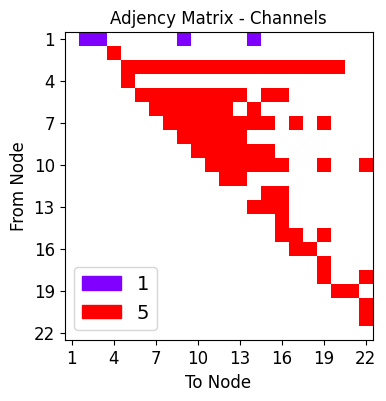

Network 5


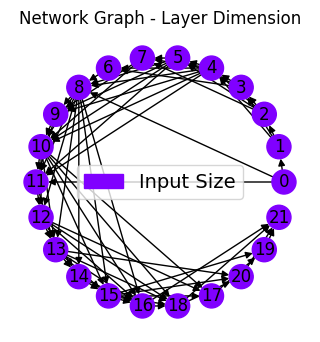

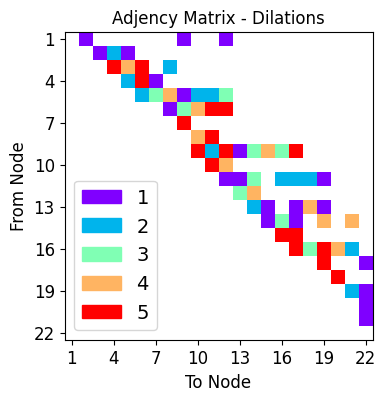

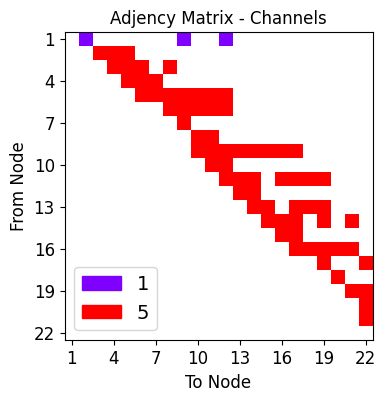

In [10]:
# SMSNet parameters
in_channels = 1
out_channels = 1 
num_layers = 20

# When alpha > 0, short-range skip connections are favoured
alpha = 0.75

# When gamma is 0, the degree of each node is chosen uniformly between 0 and max_k
# specifically, P(degree) \propto degree^-gamma
gamma = 0.75

# we can limit the maximum and minimum degree of our graph 
max_k = num_layers
min_k = 1

# features channel posibilities per edge
hidden_out_channels = [5] 

# possible dilation choices
dilation_choices = [1,2,3,4,5] 

# Here are some parameters that define how networks are drawn at random
# the layer probabilities dictionairy define connections
layer_probabilities={'LL_alpha': alpha,
                     'LL_gamma': gamma,
                     'LL_max_degree':max_k,
                     'LL_min_degree':min_k,
                     'IL': 0.1,
                     'LO': 0.1,
                     'IO': False}

# if desired, one can introduce scale changes (down and upsample)
# a not-so-thorough look indicates that this isn't really super beneficial
# in the model systems we looked at
sizing_settings = {'stride_base':2, #better keep this at 2
                   'min_power': 0,
                   'max_power': 0}

# defines the type of network we want to build

network_type = "Regression"

nets = [] 
n_networks = 5
epochs = 100     # Set number of epochs
criterion = nn.L1Loss()   # For segmenting 
learning_rate = 1e-3

for ii in range(n_networks):
    torch.cuda.empty_cache()
    print("Network %i"%(ii+1))
    smsnet_model = smsnet.random_SMS_network(in_channels=in_channels,
                                             out_channels=out_channels,
                                             in_shape=(32,32),
                                             out_shape=(32,32),
                                             sizing_settings=sizing_settings,
                                             layers=num_layers,
                                             dilation_choices=dilation_choices,
                                             hidden_out_channels=hidden_out_channels,
                                             layer_probabilities=layer_probabilities,
                                             network_type=network_type
                                            )
    
    # lets plot the network
    net_plot,dil_plot,chan_plot = draw_sparse_network.draw_network(smsnet_model)
    plt.show()

    nets.append(smsnet_model)
    

In [11]:
for net in nets:
    print("Start training")
    pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
    print("Total number of refineable parameters: ", pytorch_total_params)

    optimizer = optim.Adam(net.parameters(), lr=learning_rate)  # Defined in loop, one per network    
    device = helpers.get_device()
    print(f'Using device: {device}')
    net = net.to(device)
    tmp = train_regression(net,
                           train_loader,
                           validation_loader,
                           epochs,
                           criterion,
                           optimizer,
                           device,
                           show=1,
                           use_amp=True)    
    smsnet_model = net.cpu()
    plots.plot_training_results_regression(tmp[1]).show()
    # plots.plot_training_results_segmentation(tmp[1]).show()
    
    # with torch.no_grad():
    #     tmp_tmp = net(OBS[-1:,...]).cpu()
        
    #     plt.imshow(np.exp(OBS[-1:,0,...].numpy()[0]))
    #     plt.show()
        
    #     plt.imshow(np.exp(tmp_tmp[0,0].numpy()))
    #     plt.show()
        
    #     plt.imshow(np.exp(GT[-1:,0,...].numpy()[0]))
    #     plt.show()
        
    
    
    

Start training
Total number of refineable parameters:  32457
Using device: cuda:0
Epoch 1 of 100 | Learning rate 1.000e-03
Training Loss: 4.3698e-02 | Validation Loss: 2.3267e-02
Training CC: 0.2479   Validation CC  : 0.4599 
Epoch 2 of 100 | Learning rate 1.000e-03
Training Loss: 2.3144e-02 | Validation Loss: 2.3907e-02
Training CC: 0.3658   Validation CC  : 0.4237 
Epoch 3 of 100 | Learning rate 1.000e-03
Training Loss: 1.9917e-02 | Validation Loss: 1.8780e-02
Training CC: 0.4159   Validation CC  : 0.4396 
Epoch 4 of 100 | Learning rate 1.000e-03
Training Loss: 1.7313e-02 | Validation Loss: 1.8183e-02
Training CC: 0.4558   Validation CC  : 0.5233 
Epoch 5 of 100 | Learning rate 1.000e-03
Training Loss: 1.7173e-02 | Validation Loss: 2.0182e-02
Training CC: 0.4515   Validation CC  : 0.4970 
Epoch 6 of 100 | Learning rate 1.000e-03
Training Loss: 1.5981e-02 | Validation Loss: 1.8475e-02
Training CC: 0.4880   Validation CC  : 0.5536 
Epoch 7 of 100 | Learning rate 1.000e-03
Training Loss

Start training
Total number of refineable parameters:  22187
Using device: cuda:0
Epoch 1 of 100 | Learning rate 1.000e-03
Training Loss: 4.5900e-02 | Validation Loss: 3.1977e-02
Training CC: 0.2051   Validation CC  : 0.1373 
Epoch 2 of 100 | Learning rate 1.000e-03
Training Loss: 2.3857e-02 | Validation Loss: 2.1608e-02
Training CC: 0.2966   Validation CC  : 0.4201 
Epoch 3 of 100 | Learning rate 1.000e-03
Training Loss: 2.0422e-02 | Validation Loss: 2.1007e-02
Training CC: 0.3410   Validation CC  : 0.4169 
Epoch 4 of 100 | Learning rate 1.000e-03
Training Loss: 1.8421e-02 | Validation Loss: 2.0845e-02
Training CC: 0.3499   Validation CC  : 0.3045 
Epoch 5 of 100 | Learning rate 1.000e-03
Training Loss: 1.8245e-02 | Validation Loss: 1.9607e-02
Training CC: 0.3593   Validation CC  : 0.3391 
Epoch 6 of 100 | Learning rate 1.000e-03
Training Loss: 1.7486e-02 | Validation Loss: 1.9548e-02
Training CC: 0.4125   Validation CC  : 0.5203 
Epoch 7 of 100 | Learning rate 1.000e-03
Training Loss

Start training
Total number of refineable parameters:  45742
Using device: cuda:0
Epoch 1 of 100 | Learning rate 1.000e-03
Training Loss: 3.9271e-02 | Validation Loss: 2.9420e-02
Training CC: 0.1480   Validation CC  : 0.3200 
Epoch 2 of 100 | Learning rate 1.000e-03
Training Loss: 2.4096e-02 | Validation Loss: 2.3132e-02
Training CC: 0.2783   Validation CC  : 0.1027 
Epoch 3 of 100 | Learning rate 1.000e-03
Training Loss: 1.8744e-02 | Validation Loss: 1.9158e-02
Training CC: 0.3714   Validation CC  : 0.4744 
Epoch 4 of 100 | Learning rate 1.000e-03
Training Loss: 1.8522e-02 | Validation Loss: 1.8963e-02
Training CC: 0.4083   Validation CC  : 0.3699 
Epoch 5 of 100 | Learning rate 1.000e-03
Training Loss: 1.7865e-02 | Validation Loss: 2.3820e-02
Training CC: 0.4174   Validation CC  : 0.2520 
Epoch 6 of 100 | Learning rate 1.000e-03
Training Loss: 1.8055e-02 | Validation Loss: 2.2427e-02
Training CC: 0.4383   Validation CC  : 0.3259 
Epoch 7 of 100 | Learning rate 1.000e-03
Training Loss

Start training
Total number of refineable parameters:  62699
Using device: cuda:0
Epoch 1 of 100 | Learning rate 1.000e-03
Training Loss: 3.9186e-02 | Validation Loss: 2.5422e-02
Training CC: 0.2685   Validation CC  : 0.3743 
Epoch 2 of 100 | Learning rate 1.000e-03
Training Loss: 2.3086e-02 | Validation Loss: 2.0584e-02
Training CC: 0.3736   Validation CC  : 0.4875 
Epoch 3 of 100 | Learning rate 1.000e-03
Training Loss: 1.8133e-02 | Validation Loss: 1.7938e-02
Training CC: 0.4729   Validation CC  : 0.5555 
Epoch 4 of 100 | Learning rate 1.000e-03
Training Loss: 1.7633e-02 | Validation Loss: 2.3471e-02
Training CC: 0.4817   Validation CC  : 0.5518 
Epoch 5 of 100 | Learning rate 1.000e-03
Training Loss: 1.5966e-02 | Validation Loss: 1.6866e-02
Training CC: 0.5732   Validation CC  : 0.6458 
Epoch 6 of 100 | Learning rate 1.000e-03
Training Loss: 1.6612e-02 | Validation Loss: 2.1456e-02
Training CC: 0.5727   Validation CC  : 0.5965 
Epoch 7 of 100 | Learning rate 1.000e-03
Training Loss

Start training
Total number of refineable parameters:  48352
Using device: cuda:0
Epoch 1 of 100 | Learning rate 1.000e-03
Training Loss: 5.0645e-02 | Validation Loss: 2.7415e-02
Training CC: 0.1795   Validation CC  : 0.2924 
Epoch 2 of 100 | Learning rate 1.000e-03
Training Loss: 2.7100e-02 | Validation Loss: 2.9661e-02
Training CC: 0.2851   Validation CC  : 0.3261 
Epoch 3 of 100 | Learning rate 1.000e-03
Training Loss: 2.4437e-02 | Validation Loss: 2.2014e-02
Training CC: 0.3121   Validation CC  : 0.4176 
Epoch 4 of 100 | Learning rate 1.000e-03
Training Loss: 1.9455e-02 | Validation Loss: 2.2330e-02
Training CC: 0.4425   Validation CC  : 0.5264 
Epoch 5 of 100 | Learning rate 1.000e-03
Training Loss: 1.8438e-02 | Validation Loss: 1.7862e-02
Training CC: 0.4470   Validation CC  : 0.5722 
Epoch 6 of 100 | Learning rate 1.000e-03
Training Loss: 1.8209e-02 | Validation Loss: 2.2495e-02
Training CC: 0.5150   Validation CC  : 0.6011 
Epoch 7 of 100 | Learning rate 1.000e-03
Training Loss

KeyboardInterrupt: 

In [12]:
bilbo = baggins.model_baggin(nets[::-1], model_type="regression", returns_normalized=False)

In [ ]:
for i, net in enumerate(nets[::-1]):
    net_name = f'nets\\10272023\\sparse_net_{i}.pth'
    torch.save(net.state_dict(), net_name)

In [59]:
test_data = NpyDataset(start_idx=0, end_idx=2, Y=Y, X=X, window=window, step=step, border=border, border_weight=border_weight)
t_d = qlty_obj.stitch(torch.unsqueeze(torch.concat([test_data[i][0] for i in range(16)]), 1))
print(t_d[0].shape)
m,s = bilbo(t_d[0], return_std=True)
print(m.shape)

torch.Size([1, 1, 1024, 1024])
torch.Size([1, 1, 1024, 1024])


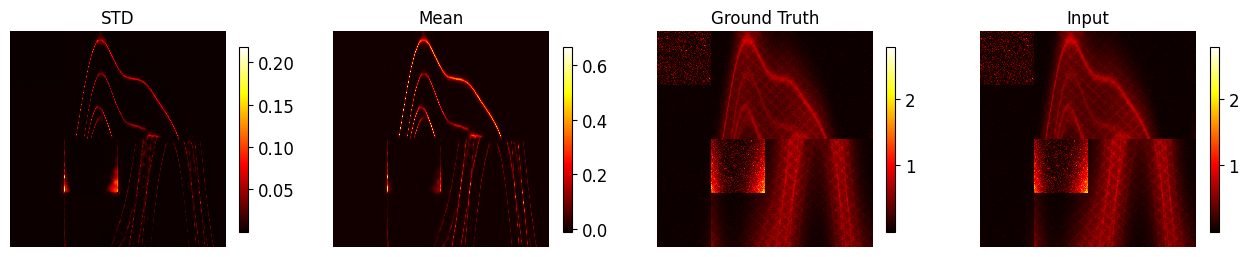

IndexError: index 1 is out of bounds for dimension 0 with size 1

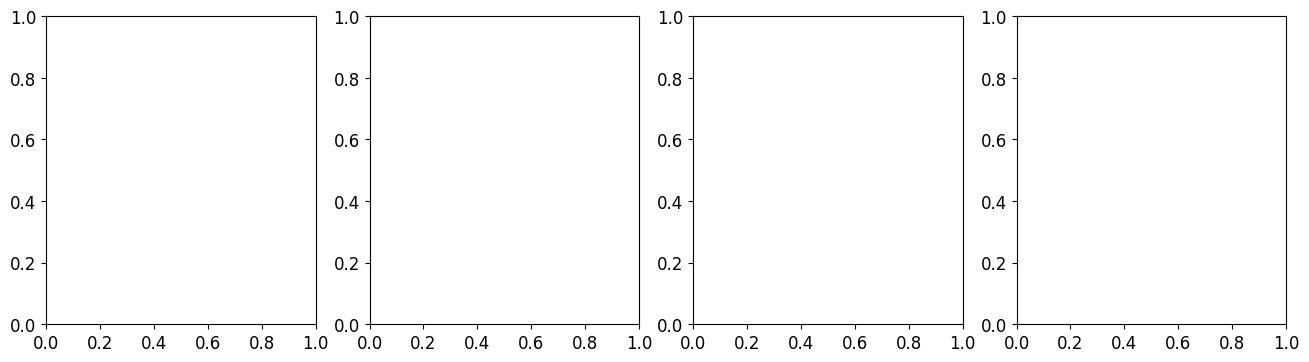

In [66]:
for ii in range(5):
    
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    # Plot the heatmaps
    axs[1].imshow(m[ii,0], cmap='hot', interpolation='none')
    axs[1].set_title('Mean')
    axs[1].axis('off')

    axs[0].imshow(s[ii,0], cmap='hot', interpolation='none')
    axs[0].set_title('STD')
    axs[0].axis('off')

    axs[2].imshow(t_d[0][0][0,:,:], cmap='hot', interpolation='none')
    axs[2].set_title('Ground Truth')
    axs[2].axis('off')

    axs[3].imshow(t_d[0][0][0,:,:], cmap='hot', interpolation='none')
    axs[3].set_title('Input')
    axs[3].axis('off')

    # Show colorbars for each subplot
    for ax in axs:
        plt.colorbar(mappable=ax.get_images()[0], ax=ax, orientation='vertical', shrink=0.6)

    # Show the plots
    plt.show()
    
    
    print()